In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Load and Explore Data

In [2]:
data=pd.read_csv('dataset/IMDB Dataset.csv')

In [3]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
# Check distribution of target variable

data['sentiment'].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# 2. Data Preprocessing

In [5]:
# Change the target variable to binary
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

In [6]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


## Lowercase

In [7]:
pre_data = data.copy()

In [8]:
# Lowercase
pre_data['review'] = pre_data['review'].apply(lambda x: x.lower())

In [9]:
pre_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,"bad plot, bad dialogue, bad acting, idiotic di...",0
49997,i am a catholic taught in parochial elementary...,0
49998,i'm going to have to disagree with the previou...,0


## Remove punctuation, urls, names

In [10]:
# remove html tags
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [11]:
# Apply the function to the 'text' column
pre_data['review'] = pre_data['review'].apply(remove_html_tags)

In [12]:
pre_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,"bad plot, bad dialogue, bad acting, idiotic di...",0
49997,i am a catholic taught in parochial elementary...,0
49998,i'm going to have to disagree with the previou...,0


In [13]:
# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


In [14]:
pre_data['review'] = pre_data['review'].str.replace(f'[{string.punctuation}]', '', regex=True)

In [15]:
pre_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,im going to have to disagree with the previous...,0


## Remove stop words

In [16]:
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    # Split the text into words
    words = text.split()
    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Join the words back into a sentence
    return ' '.join(filtered_words)

In [17]:
pre_data['review'] = pre_data['review'].apply(remove_stopwords)

In [18]:
pre_data

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary schools n...,0
49998,im going disagree previous comment side maltin...,0


## Stemming

In [19]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to perform stemming
def stem_text(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in words]
    # Join the stemmed words back into a sentence
    return ' '.join(stemmed_words)


In [20]:
pre_data['review'] = pre_data['review'].apply(stem_text)

In [21]:
pre_data

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy jake think there ...,0
4,petter mattei love time money visual stun film...,1
...,...,...
49995,thought movi right good job wasnt creativ orig...,1
49996,bad plot bad dialogu bad act idiot direct anno...,0
49997,cathol taught parochi elementari school nun ta...,0
49998,im go disagre previou comment side maltin one ...,0


## Tokenize sentences

In [22]:
# Tokenize the sentences
pre_data['review'] = pre_data['review'].apply(word_tokenize)

In [23]:
pre_data

,review,sentiment
0,"[one, review, mention, watch, 1, oz, episod, y...",1
1,"[wonder, littl, product, film, techniqu, unass...",1
2,"[thought, wonder, way, spend, time, hot, summe...",1
3,"[basic, there, famili, littl, boy, jake, think...",0
4,"[petter, mattei, love, time, money, visual, st...",1
...,...,...
49995,"[thought, movi, right, good, job, wasnt, creat...",1
49996,"[bad, plot, bad, dialogu, bad, act, idiot, dir...",0
49997,"[cathol, taught, parochi, elementari, school, ...",0
49998,"[im, go, disagre, previou, comment, side, malt...",0


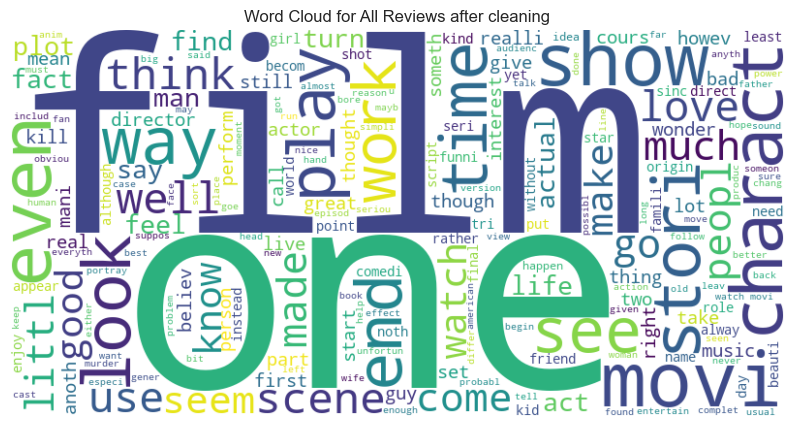

In [24]:
all_reviews = " ".join(" ".join(review) for review in pre_data['review'])
all_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews after cleaning')
plt.show()

# 3. Vectorization

In [25]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(pre_data['review'].apply(lambda x: ' '.join(x)))
y = pre_data['sentiment']

# 4. Train Model

## Split data

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train model

In [27]:
# Khởi tạo mô hình Naive Bayes
model = MultinomialNB()

In [28]:
# Thiết lập các giá trị alpha cần thử nghiệm
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

In [29]:
# Sử dụng Grid Search để tìm giá trị alpha tốt nhất
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]})

In [30]:
# In ra giá trị alpha tốt nhất
print(f'Best alpha: {grid_search.best_params_["alpha"]}')

Best alpha: 1.0


In [31]:
# Dự đoán và đánh giá mô hình với giá trị alpha tốt nhất
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [32]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8568


In [33]:
train_y_pred = best_model.predict(X_train)

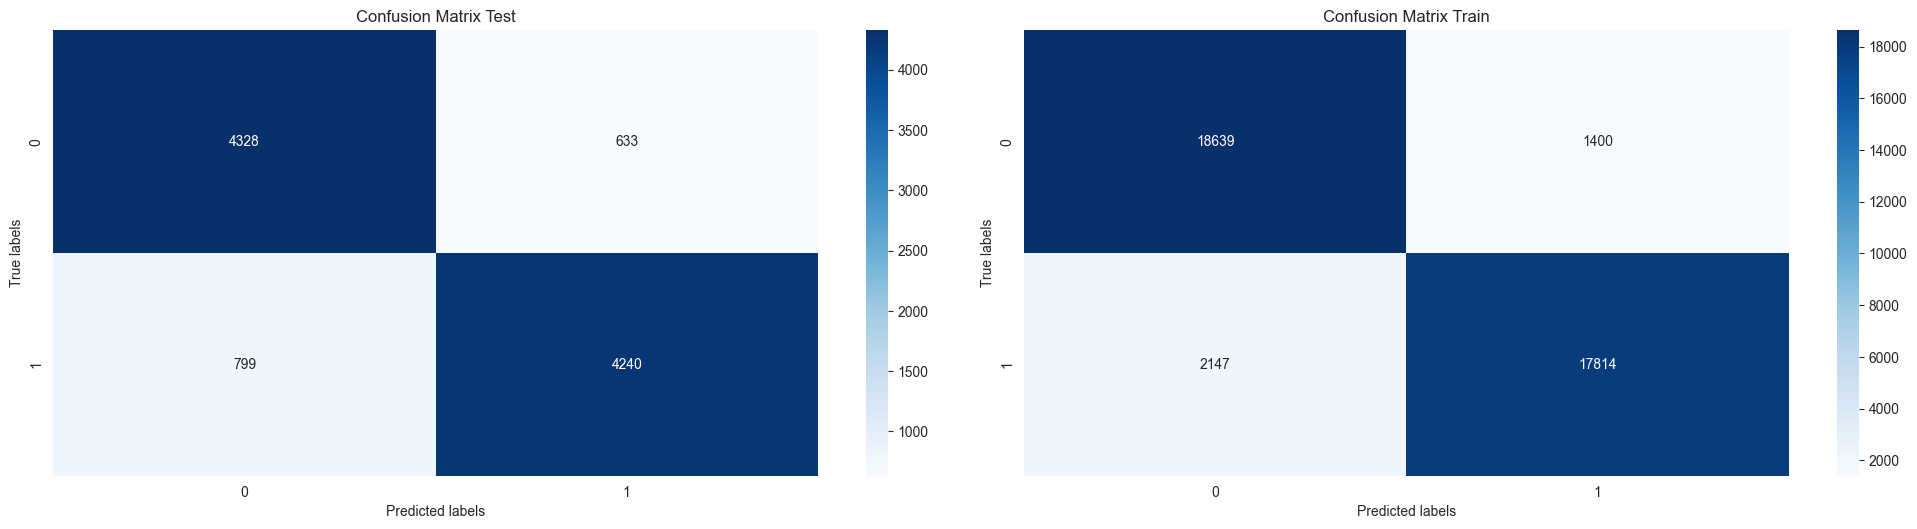

In [34]:
# Convert predictions to binary
y_pred_binary = (y_pred > 0.5).astype(int)
y_pred_train_binary = (train_y_pred > 0.5).astype(int)

plt.figure(figsize=(20, 10))

# Confusion Matrix for Test Set
plt.subplot(2, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test')

# Confusion Matrix for Train Set
plt.subplot(2, 2, 2)
sns.heatmap(confusion_matrix(y_train, y_pred_train_binary), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Train')

plt.tight_layout()
plt.show()

In [35]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4961
           1       0.87      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [36]:
print(classification_report(y_train, y_pred_train_binary))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     20039
           1       0.93      0.89      0.91     19961

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000

